In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Importieren des Datensets

In [2]:
DF = pd.read_csv('train_strokes.csv')

## Analyse des Datensets

In [3]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


Wir haben Missing Values bei dem BMI und dem Smoking Status. Weiterhin ist die ID nicht relevant.

<AxesSubplot:>

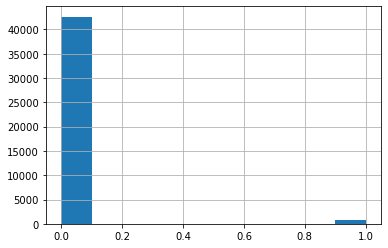

In [4]:
DF.stroke.hist()

In [5]:
DF['stroke'].sum()

783

Wir haben eine extrem ungleiche Verteilung in dem Datenset. So haben gerade einmal 783 von den 43400 Instanzen einen Schlaganfall erlitten.

## Speichern des Test- und Trainsets

Wir sondern das Testset aus, welches später in der App eingespeist werden soll.

In [6]:
df, testdaten = train_test_split(DF, random_state = 1, test_size = 0.1)

In [7]:
testdaten.to_csv('new_customers.csv', index = False)

In [8]:
df.to_csv('trainingsdata.csv', index = False)

# Aufbereitung des Datensets

### ID

Wir droppen die ID.

In [9]:
df = df.drop('id', axis = 1)
df['age'] =  df['age'].astype(int)

## Smoking Status

Wir nehmen an, dass Kinder bis 9 Jahre noch nie in ihrem Leben geraucht haben, da wir bis dahin nur missing values haben. Bei dem Rest fügen wir Unknown ein.

In [10]:
df.loc[(df['age'] <= 9, ['smoking_status'])] = df.loc[(df['age'] <= 9, ['smoking_status'])].fillna('never smoked')
df.loc[(df['age'] > 9 , ['smoking_status'])] = df.loc[(df['age'] > 9, ['smoking_status'])].fillna('unknown')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39060 entries, 39960 to 33003
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             39060 non-null  object 
 1   age                39060 non-null  int64  
 2   hypertension       39060 non-null  int64  
 3   heart_disease      39060 non-null  int64  
 4   ever_married       39060 non-null  object 
 5   work_type          39060 non-null  object 
 6   Residence_type     39060 non-null  object 
 7   avg_glucose_level  39060 non-null  float64
 8   bmi                37748 non-null  float64
 9   smoking_status     39060 non-null  object 
 10  stroke             39060 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 3.6+ MB


## BMI

## Imputieren des BMI mittels Mean

In [34]:
male_bmi = df[df['gender'] == 'Male'][['bmi', 'age']].dropna()
female_bmi = df[df['gender'] == 'Female'][['bmi', 'age']].dropna()
other_bmi = df[df['gender'] == 'Other'][['bmi', 'age']].dropna()

In [13]:
male_bmi = male_bmi.groupby('age').mean()
female_bmi = female_bmi.groupby('age').mean()
other_bmi = other_bmi.groupby('age').mean()

In [14]:
total_bmi = df[['age', 'bmi']].dropna()
total_bmi = total_bmi.groupby('age').mean()

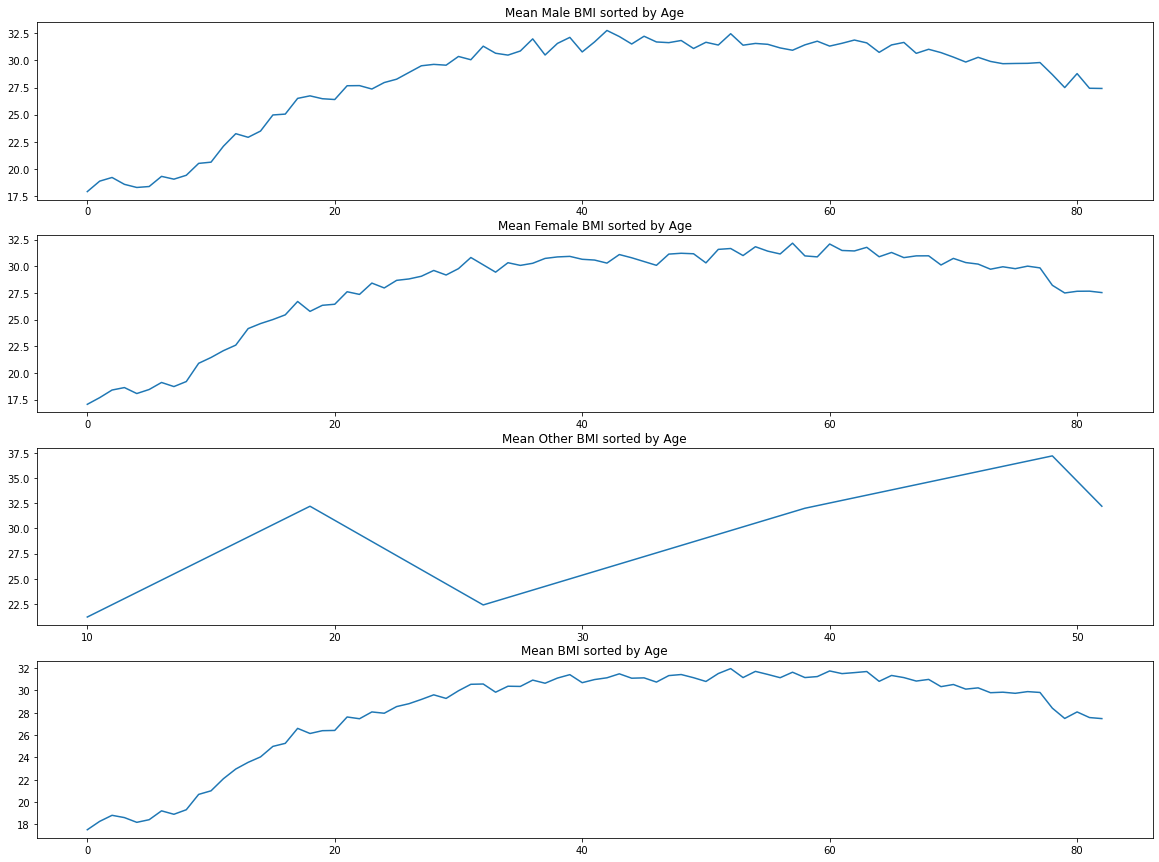

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (20, 15))
ax1.plot(male_bmi.index, male_bmi.bmi)
ax1.set_title('Mean Male BMI sorted by Age')
ax2.plot(female_bmi.index, female_bmi.bmi)
ax2.set_title('Mean Female BMI sorted by Age')
ax3.plot(other_bmi.index, other_bmi.bmi)
ax3.set_title('Mean Other BMI sorted by Age')
ax4.plot(total_bmi.index, total_bmi.bmi)
ax4.set_title('Mean BMI sorted by Age')
plt.show()

Wir imputieren die Missing Values der Males und Females mittels der jeweiligen Means. Bei den Others haben wir zu wenig Values, weshalb wir hier den Mean des gesamten Datensets nehmen. Es ist ein recht klarer Zusammenhanz zwischen dem Alter und dem BMI festzustellen.

In [16]:
def imputing_bmi(dataset):
    male_bmi = df[df['gender'] == 'Male'][['bmi', 'age']].dropna()
    female_bmi = df[df['gender'] == 'Female'][['bmi', 'age']].dropna()
    other_bmi = df[df['gender'] == 'Other'][['bmi', 'age']].dropna()
    male_bmi = male_bmi.groupby('age').mean()
    female_bmi = female_bmi.groupby('age').mean()
    other_bmi = other_bmi.groupby('age').mean()
    total_bmi = df[['age', 'bmi']].dropna()
    total_bmi = total_bmi.groupby('age').mean()
    
    for i in dataset.loc[(dataset['gender'] == 'Male') & (dataset['bmi'].isnull())].index:
        age = dataset.loc[i]['age']
        bmi = male_bmi.iloc[age]
        dataset.loc[i] = dataset.loc[i].fillna(bmi)
    for i in dataset.loc[(df['gender'] == 'Female') & (dataset['bmi'].isnull())].index:
        age = dataset.loc[i]['age']
        bmi = female_bmi.iloc[age]
        dataset.loc[i] = dataset.loc[i].fillna(bmi)
    for i in dataset.loc[(df['gender'] == 'Other') & (dataset['bmi'].isnull())].index:
        age = dataset.loc[i]['age']
        bmi = total_bmi.iloc[age]
        dataset.loc[i] = dataset.loc[i].fillna(bmi)
        
    return dataset
    

In [17]:
df = imputing_bmi(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39060 entries, 39960 to 33003
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             39060 non-null  object 
 1   age                39060 non-null  int64  
 2   hypertension       39060 non-null  int64  
 3   heart_disease      39060 non-null  int64  
 4   ever_married       39060 non-null  object 
 5   work_type          39060 non-null  object 
 6   Residence_type     39060 non-null  object 
 7   avg_glucose_level  39060 non-null  float64
 8   bmi                39060 non-null  float64
 9   smoking_status     39060 non-null  object 
 10  stroke             39060 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 4.6+ MB


# Trennen der Testdaten und Erstellen der Dummies

Wir trennen nun die Trainings und die Testdaten und erstellen Dummies für die Objects in dem Datenset.

In [19]:
X = df.drop('stroke', axis = 1)
y = df['stroke']

In [20]:
X = pd.get_dummies(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)

In [22]:
def report(predictions, true = y_test):
    return print(classification_report(true, predictions), confusion_matrix(true, predictions))

# Random Forest Regressor

Nachdem wir viele verschiedene Modelle ausprobiert haben, sind wir bei dem Random Forest Regressor auf die besten Ergebnisse gestossen. Die Versuche befinden sich in einem anderen Notebook, können aber bei Bedarf auch eingesehen werden. Um die Ergebnisse reproduzierbar zu machen, setzen wir den Random State gleich 1.

In [23]:
rfr = RandomForestRegressor(random_state = 1)

In [24]:
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [25]:
preds_reg = rfr.predict(X_test)

In [26]:
preds_r = (preds_reg>0.01).astype(int)

In [27]:
print (report(preds_r))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      7688
           1       0.04      0.77      0.08       124

    accuracy                           0.73      7812
   macro avg       0.52      0.75      0.46      7812
weighted avg       0.98      0.73      0.83      7812
 [[5640 2048]
 [  29   95]]
None


# ROC curve

In [74]:
fpr, tpr, thresholds = roc_curve(y_test, preds_reg)

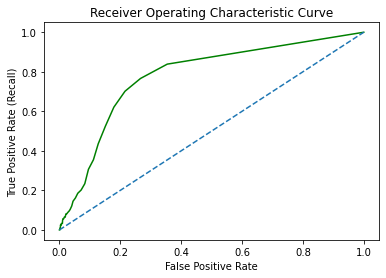

In [75]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color="green")
ax.plot([0,1],[0,1], "--")

ax.set_title("Receiver Operating Characteristic Curve")
ax.set_ylabel("True Positive Rate (Recall)")
ax.set_xlabel("False Positive Rate")
plt.show()

In [76]:
roc_auc_score(y_test, preds_reg)

0.7784822807223658

# Hyperparameter tuning

Wir tunen nun unseren Random Forest Regressor mittels Grid Search CV.

In [140]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [141]:
params = {'max_depth': range(50, 101, 10),
         'n_estimators': [100, 125, 150],
         'min_samples_leaf': range(1, 5),
         'random_state': [1]}

In [145]:
5*3*4*5

300

In [146]:
forest_CV = GridSearchCV(rfr, params, cv = 5, n_jobs = -1)

In [147]:
forest_CV.fit(X_train, y_train)
%notify

<IPython.core.display.Javascript object>

In [148]:
forest_CV.best_params_

{'max_depth': 50,
 'min_samples_leaf': 4,
 'n_estimators': 125,
 'random_state': 1}

In [149]:
preds_tuned = forest_CV.predict(X_test)

In [150]:
fpr, tpr, thresholds = roc_curve(y_test, preds_tuned)

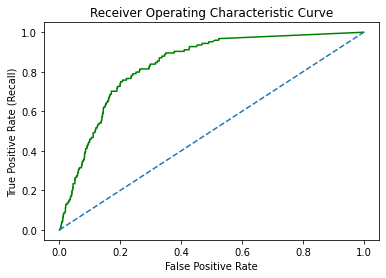

In [151]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color="green")
ax.plot([0,1],[0,1], "--")

ax.set_title("Receiver Operating Characteristic Curve")
ax.set_ylabel("True Positive Rate (Recall)")
ax.set_xlabel("False Positive Rate")
plt.show()

In [152]:
roc_auc_score(y_test, preds_tuned)

0.8352837266288476

#  Speichern des Modells

In [153]:
import pickle

In [154]:
filename = 'tuned_model.sav'

In [155]:
pickle.dump(forest_CV, open(filename, 'wb'))

# Mean der Strokes (nur testweise)

In [32]:
male_stroke.groupby('age').mean()

In [59]:
male = df[df['gender'] == 'Male'][['age', 'stroke']].groupby('age').mean()
female = df[df['gender'] == 'Female'][['age', 'stroke']].groupby('age').mean()
other = df[df['gender'] == 'Other'][['age', 'stroke']].groupby('age').mean()
general = df[['age', 'stroke']].groupby('age').mean()

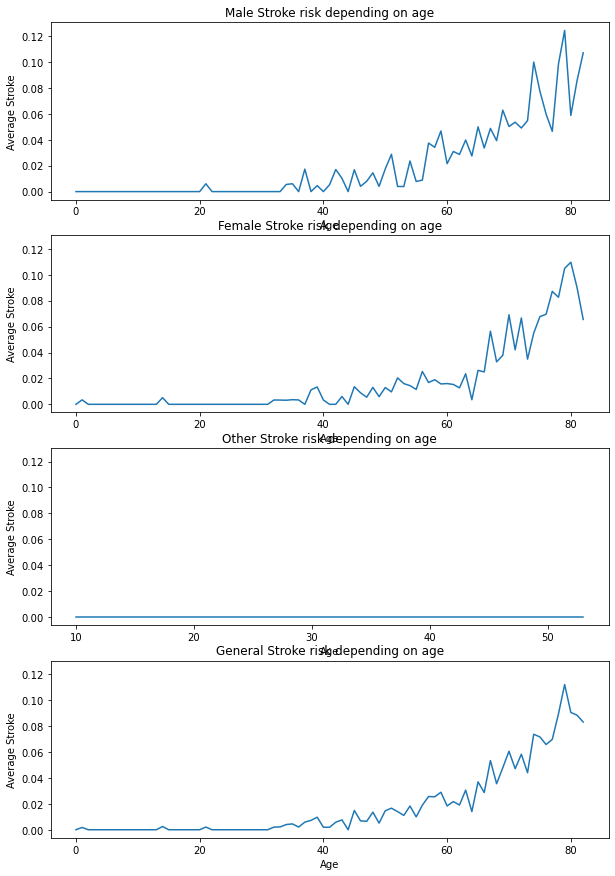

In [66]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (10,15), sharey = True)

ax1.plot(male)
ax1.set_xlabel('Age')
ax1.set_ylabel('Average Stroke')
ax1.set_title('Male Stroke risk depending on age')

ax2.plot(female)
ax2.set_xlabel('Age')
ax2.set_ylabel('Average Stroke')
ax2.set_title('Female Stroke risk depending on age')


ax3.plot(other)
ax3.set_xlabel('Age')
ax3.set_ylabel('Average Stroke')
ax3.set_title('Other Stroke risk depending on age')

ax4.plot(general)
ax4.set_xlabel('Age')
ax4.set_ylabel('Average Stroke')
ax4.set_title('General Stroke risk depending on age')

plt.show()

In [83]:
len(DF[DF['gender']== 'Other'])

11

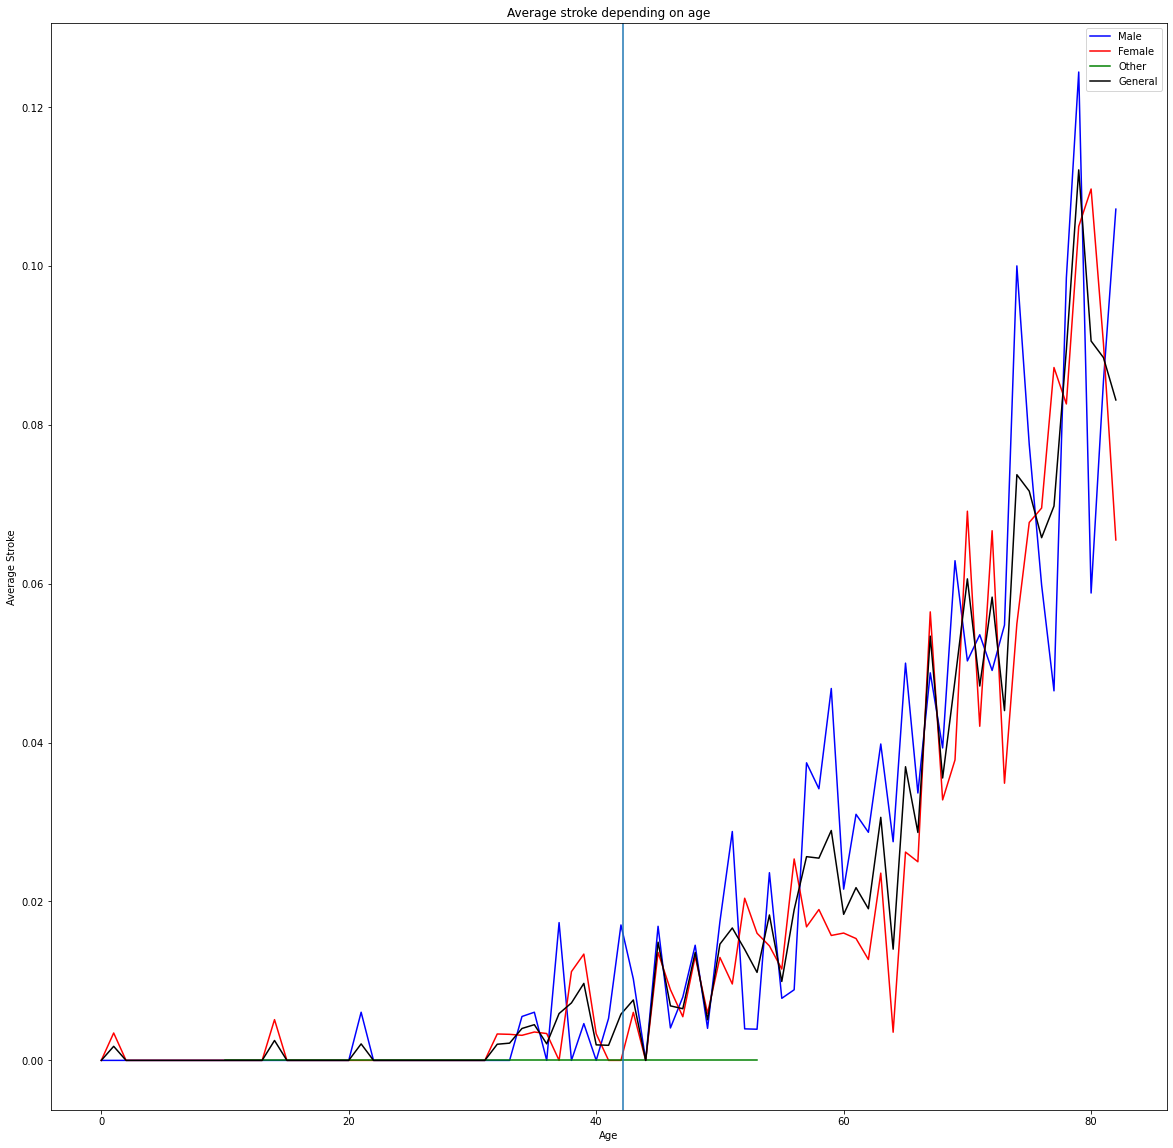

In [90]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.plot(male, color = 'blue', label = 'Male')
ax.plot(female, color = 'red', label = 'Female')
ax.plot(other, color = 'green', label = 'Other')
ax.plot(general, color = 'black', label = 'General')
ax.axvline(df['age'].mean())

ax.set_ylabel('Average Stroke')
ax.set_xlabel('Age')
ax.set_title('Average stroke depending on age')
ax.legend()
plt.show()

# Modell

In [134]:
modell = pickle.load(open('tuned_model.sav', 'rb'))

/Users/nikolausfischer-zernin/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nikolausfischer-zernin/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nikolausfischer-zernin/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [139]:
modell.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 125, 'random_state': 1}